## Kernel to load: vax_inc_geo

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from textwrap import wrap
import rasterio 
import rasterio.plot
import matplotlib
import jenkspy
import random
import matplotlib.patches as mpatches
import os
import warnings
warnings.simplefilter("ignore", UserWarning)
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

Cannot find header.dxf (GDAL_DATA is not defined)


# Must run 'Arcpy_Current pop size maps (Cattle, chickens, and swine).ipynb' before this code

In [2]:
notebook_dir = os.path.dirname(os.getcwd())
source_data_path=os.path.join(notebook_dir, "Common Source Data")

In [3]:
all_files=[]
for path, subdirs, files in os.walk('ARCPY Maps/'):
    for name in files:
        all_files+=[path+
                    '/'+name.replace('\\\\','/')]
        
files_pops=[i for i in all_files if 'log_scaled_pop_density_plus_1_(plot).tif' in i if i[-4:]=='.tif']


In [4]:
animal_pop_dict=dict()
for file in files_pops:
    animal=file.split('/')[1].split('\\')[1]
    animal_pop_dict[(animal)]=file

In [5]:
SHAPEFILE = os.path.join(source_data_path,'ne_10m_admin_0_countries','ne_10m_admin_0_countries.shp')
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

geo_df.columns = ['country', 'country_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)
geo_df.reset_index(drop=True, inplace=True)

0.0 3.5609403
Cattle


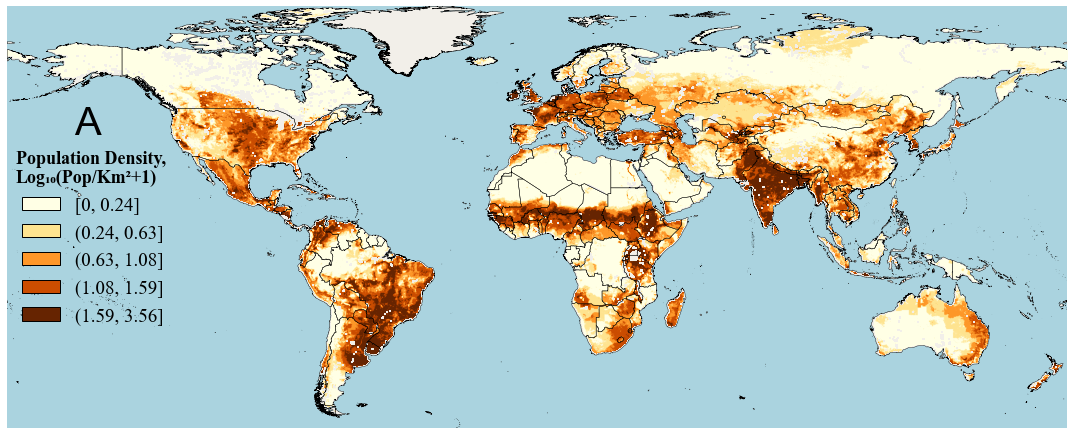

0.0 3.5624163
Swine


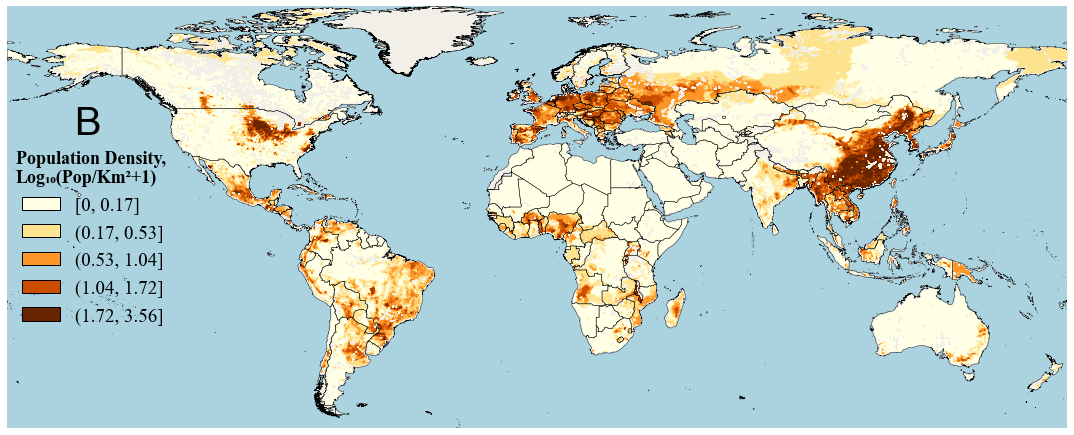

0.0 5.115904
Poultry


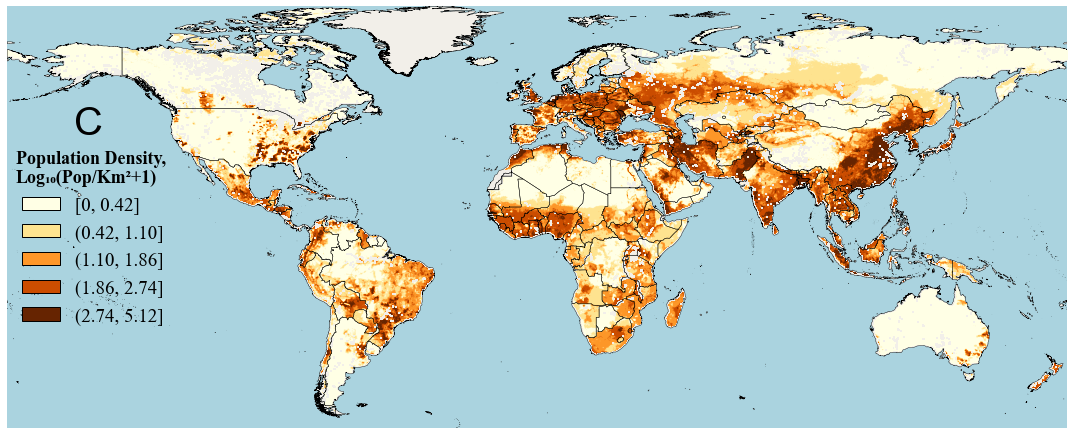

In [6]:
for i,animal in enumerate(['Cattle','Swine','Poultry']):

    raster_path = animal_pop_dict[animal]    
    
    raster = rasterio.open(raster_path)
    highest_resolution = raster.res[0]
    
    raster_data = raster.read(1)  
    
    left, bottom, right, top = raster.bounds
    
    cmap_custom=matplotlib.colors.LinearSegmentedColormap.from_list("", ["ivory","orange","saddlebrown"])
    
    raster_data = np.where(raster_data == raster_data[0][0], np.nan, raster_data)
    vmax_ultimate=np.nanmax(raster_data)
    vmin_ultimate=np.nanmin(raster_data)
    
    print(vmin_ultimate,vmax_ultimate)
    raster_flat = raster_data.flatten()
    jenks_vals = raster_flat[~np.isnan(raster_flat)].tolist()

    jenks_vals=random.sample(list(jenks_vals),100000)
    
    categories=jenkspy.jenks_breaks(jenks_vals,5)
    
    
    raster_data = np.where((raster_data >=categories[0]) & (raster_data<= categories[1]),0, raster_data)
    raster_data = np.where((raster_data >categories[1]) & (raster_data<= categories[2]),0.25, raster_data)
    raster_data = np.where((raster_data >categories[2]) & (raster_data<= categories[3]),0.5, raster_data)
    raster_data = np.where((raster_data >categories[3]) & (raster_data<= categories[4]),0.75, raster_data)
    raster_data = np.where((raster_data >categories[4]),1, raster_data)
    
    
    plt.rcParams["font.family"] = "Times New Roman"
    

    fig, ax = plt.subplots(figsize=(19,17.5))
    
    colors_255 = [
        (255, 255, 229),  #This is Ivory
        (254,228,144),
        (254, 152, 41),    # Orange
        (204,77,0),
        (102, 36, 1)     # Saddlebrown
    ]
    
    colors = [(r / 255, g / 255, b / 255) for r, g, b in colors_255]

    cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

    
    ax.set_facecolor((170 / 255, 211 / 255, 223 / 255))
    
    geo_df.plot(facecolor=(242/255,239/255,233/255), edgecolor='none', ax=ax, zorder=1)
    
    vmin = np.nanmin(raster_data)
    vmax = np.nanmax(raster_data)
    im = ax.imshow(raster_data, cmap=cmap_custom, vmin=vmin, vmax=vmax, extent=(left, right, bottom, top), zorder=2)
    
    geo_df.plot(facecolor='none', edgecolor='black', linewidth=0.4, ax=ax, zorder=3)
    
    
    ax.set_aspect('equal')
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    patch1 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0), label='[0, '+'{:.2f}'.format(round(categories[1], 2))+']')
    patch2 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.25), label='('+'{:.2f}'.format(round(categories[1], 2))+', '+'{:.2f}'.format(round(categories[2], 2))+']')
    patch3 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.5), label='('+'{:.2f}'.format(round(categories[2], 2))+', '+'{:.2f}'.format(round(categories[3], 2))+']')
    patch4 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.75), label='('+'{:.2f}'.format(round(categories[3], 2))+', '+'{:.2f}'.format(round(categories[4], 2))+']')
    patch5 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(.999), label='('+'{:.2f}'.format(round(categories[4], 2))+', '+'{:.2f}'.format(round(vmax_ultimate, 2))+']')
    
    
    legend = plt.legend(bbox_to_anchor=(.17, 0.7), loc=1,
                handles=[patch1, patch2, patch3, patch4, patch5],fontsize=19,
                frameon=False)
    

    bbox = legend.get_window_extent(renderer=fig.canvas.get_renderer())
    
    bbox = bbox.transformed(ax.transAxes.inverted())
    
    x_title = bbox.x0# + (bbox.x1 - bbox.x0) / 2  # Center above the legend
    y_title = bbox.y1 - 0.01  # Slightly above the legend
    plt.rcParams["mathtext.fontset"] = "custom"
    plt.rcParams["mathtext.rm"] = "Times New Roman"
    plt.rcParams["mathtext.it"] = "Times New Roman:italic"
    plt.rcParams["mathtext.bf"] = "Times New Roman:bold"  

    
    
    legend.set_title('Population Density, \nLog₁₀(Pop/Km²+1)',prop={'size':18})


    ax.text(
        x_title+0.05, y_title+0.05,  
        chr(65 + i),  
        transform=ax.transAxes,
        fontsize=40, 
        ha='left',
        va='center',
        family='Arial'
    )




    title = legend.get_title()

    title.set_fontweight('bold')
    
    ax.set_xlim(geo_df.total_bounds[0], geo_df.total_bounds[2])
    ax.set_ylim(geo_df.total_bounds[1], geo_df.total_bounds[3])
    
    print(animal)
    
    
    os.makedirs("Population maps", exist_ok=True)

    
    plt.savefig('Population maps/'+animal+'_'+'pop density high res.svg', format='svg',
            bbox_inches='tight', pad_inches=0,dpi=600)
    plt.savefig('Population maps/'+animal+'_'+'pop density high res.png', format='png',
            bbox_inches='tight', pad_inches=0,dpi=600)
    plt.show()